Instructions: click restart and run all above. Figures will show once the entire notebook has finished running (will take a few minutes)

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import glob
import ipywidgets as widgets
from tqdm import tqdm
%matplotlib notebook

# A model to account for out of focus signal

As we saw in the previous notebook, if we don't account for out of focus light in our model, we do not get an accurate read-out of cytoplasmic and membrane concentrations. I previously argued that we don’t need a comprehensive model that simulates 3D geometry and light scattering, only two profiles that represent the net outcome of these processes for cytoplasmic and membrane protein (effectively two arrays of numbers, representing intensity at each position along the cross-cortex profile). We can take these profiles as inputs to our model, and build a simulated image with the following function:

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

def sim_img(cyt, mems, offsets, cytbg, membg, thickness=50):
    """    
    Parameters:
    cyt: single cytoplasmic concentration
    mems: membrane concentration array
    offsets: offsets array
    cytbg: cytoplasmic reference profile (length = thickness)
    membg: membrane reference profile (length = thickness)
    
    (all tensors)
    
    """
    
    nfits = offsets.shape[0]
    
    # Positions to evaluate the profiles
    positions = tf.reshape(tf.reshape(tf.tile(tf.range(thickness, dtype=np.float64), [nfits]),
                                      [nfits, thickness]) + tf.expand_dims(offsets, -1), [-1])

    # Cyt profile
    cyt_curve = tfp.math.interp_regular_1d_grid(y_ref=cytbg, x_ref_min=0, x_ref_max=1, x=positions / thickness)
    
    # Mem profile 
    mem_curve = tfp.math.interp_regular_1d_grid(y_ref=membg, x_ref_min=0, x_ref_max=1, x=positions / thickness)

    # Reshape
    cyt_curve_ = tf.reshape(cyt_curve, [nfits, thickness])
    mem_curve_ = tf.reshape(mem_curve, [nfits, thickness])

    # Scale by concentrations
    mem_total = mem_curve_ * tf.expand_dims(mems, axis=-1)
    cyt_total = cyt_curve_ * tf.expand_dims(tf.expand_dims(cyt, axis=-1), axis=-1) 
    
    # Sum membrane and cytoplasmic contributions
    return tf.transpose(tf.math.add(mem_total, cyt_total))

def loss_function(target_image, sim):
    return tf.math.reduce_mean((sim - target_image) ** 2)

Subpixel positions along each profile will be evaluated by linear interpolation (using the interp_regular_1d_grid function from the tensorflow_probability package). 

As cytoplasmic concentrations are generally assumed to be uniform (due to fast diffusion in the cytoplasm), and we assume that an accurate model will be able to work with this constraint, we can use a single number representing the global cytoplasmic concentration

The model therefore takes the following input parameters:
- a single cytoplasmic concentration parameter
- n_x membrane concentration parameters
- n_y cytoplasmic reference profile intensities
- n_y membrane reference profile intensities

We currently do not know the form of cytbg and membg that is appropriate for the model. Like sigma in the previous model, every position in each of these profiles can be thought of a global parameter that we can optimise by gradient descent. By training this model on a set of carefully chosen images, in which we can unambiguously determine the cytoplasmic or membrane contribution, we can learn the appropriate shape of these profiles directly from the data.

# Learning a cytoplasmic reference profile

To learn the shape of the cytoplasmic profile, we can simply train our model on images that only contain cytoplasmic protein, fixing membrane concentrations to zero.

### A cytoplasmic signal reporter

As a cytoplasmic signal reproter, we will use an image of PKC-3 GFP in a par-3 mutant background, which is known to be entirely cytoplasmic:

<IPython.core.display.Javascript object>


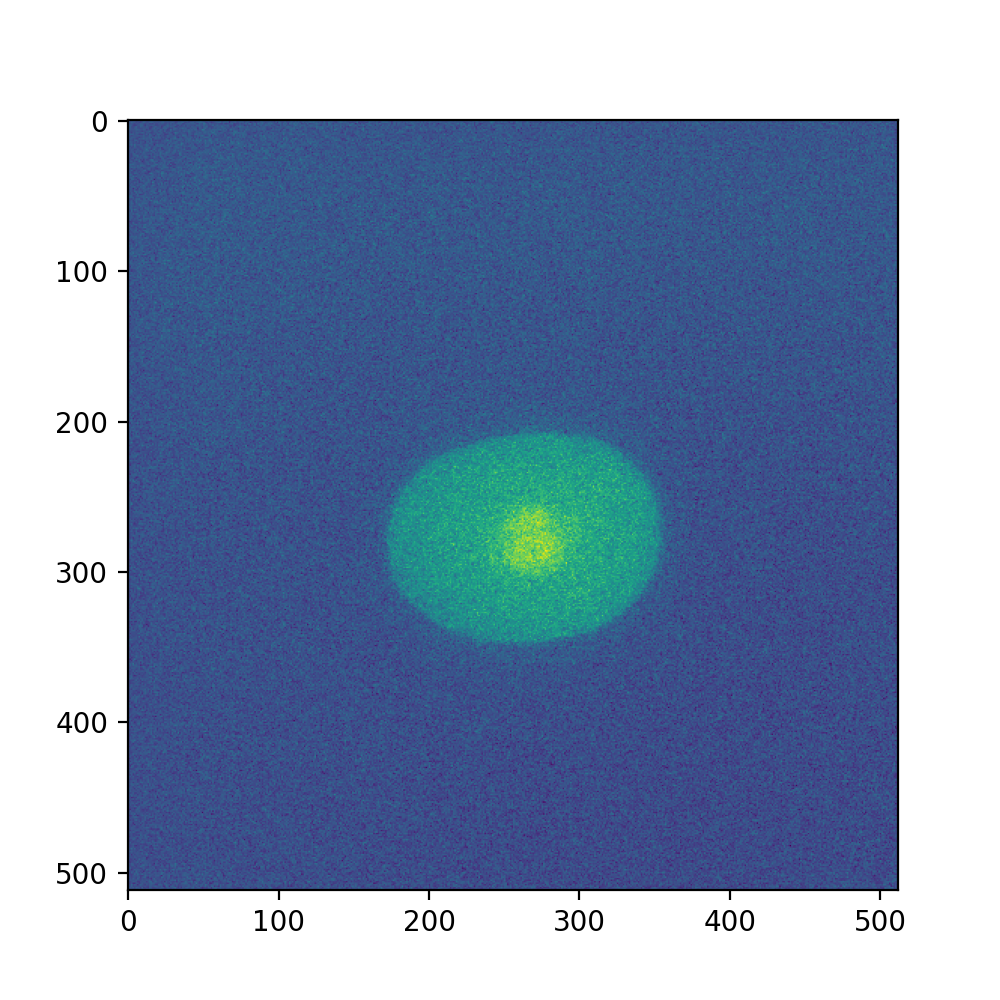

In [3]:
from membranequant.funcs import load_image, straighten

path = '../test_datasets/dataset3_pkc3_par3mutant/01/'
img = load_image(path + '/af_corrected.tif')
roi = np.loadtxt(path + '/ROI.txt')

fig, ax = plt.subplots()
ax.imshow(img)
fig.set_size_inches(5,5)

### Straighten and preprocess image

In [4]:
from membranequant.funcs import rolling_ave_2d

def preprocess(straight, rol_ave_window=20):
    straight_filtered = rolling_ave_2d(straight, window=rol_ave_window, periodic=True)
    norm = np.percentile(straight_filtered, 99)
    target = straight_filtered / norm  
    return target, norm

straight = straighten(img, roi=roi, thickness=50)
target, norm = preprocess(straight)

### Initial guess for parameters

Specifying the initial parameter values to kick off gradient descent. Concentrations and offsets can be started off at zero. We can assume that the final cytoplasmic profile will roughly resemble an error function, so will use this as the starting condition.

The shape of the membrane profile is irrelevant, as we will fix membrane concentrations zo zero 

In [5]:
from scipy.special import erf

def init_params(target, thickness=50):
    nfits = target.shape[1]
    offsets = tf.Variable(np.zeros(nfits))
    cyt = tf.Variable(np.zeros(nfits))
    mems = tf.Variable(np.zeros(nfits))
    sigma0 = 2
    cytbg = tf.Variable((1 + erf((np.arange(thickness) - thickness / 2) / sigma0)) / 2)
    membg = tf.Variable(np.zeros(thickness))
    return cyt, mems, offsets, cytbg, membg

### Perform gradient descent

By gradient descent, we will optimise cyt, offsets and cytbg (by specifying these in var_list), aiming to find a single cytoplasmic concentration and profile shape that optimises fit to the data, given free local alignment.

As all protein is cytoplasmic, mems and membg will be left at zero and not trained (excluded from var_list).

In [6]:
def optimise(target, lr=0.01, iterations=2000):
    save_gap = 10
    saved = []
    
    # Init parameters
    cyt, mems, offsets, cytbg, membg = init_params(target)
    
    # Gradient descent
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    losses = np.zeros(iterations)
    for i in tqdm(range(iterations)):   
        with tf.GradientTape() as tape:
            sim = sim_img(cyt, mems, offsets, cytbg, membg)
            loss = loss_function(target, sim)
            losses[i] = loss
            var_list = [offsets, cyt, cytbg]
            grads = tape.gradient(loss, var_list)
            opt.apply_gradients(list(zip(grads, var_list)))
        
        # Save fit
        if i == 0 or (i + 1) % save_gap == 0: 
            saved.append(sim)
        
    # Interactive plot
    fig, (ax1, ax2) = plt.subplots(2, 1)
    @widgets.interact(iteration=(0, iterations, save_gap))
    def update(iteration=0): 
        ax1.clear()
        ax1.set_title('Target')
        ax1.imshow(target, vmin=0, vmax=1)
        ax1.set_axis_off()        
        ax2.clear()
        ax2.set_title('Model')
        ax2.imshow(saved[int(iteration / save_gap)], vmin=0, vmax=1)
        ax2.set_axis_off()           
    fig.set_size_inches(7, 3)
    fig.tight_layout()
            
    return cyt, mems, offsets, cytbg, membg, losses

100%|██████████| 2000/2000 [00:52<00:00, 38.44it/s]


<IPython.core.display.Javascript object>


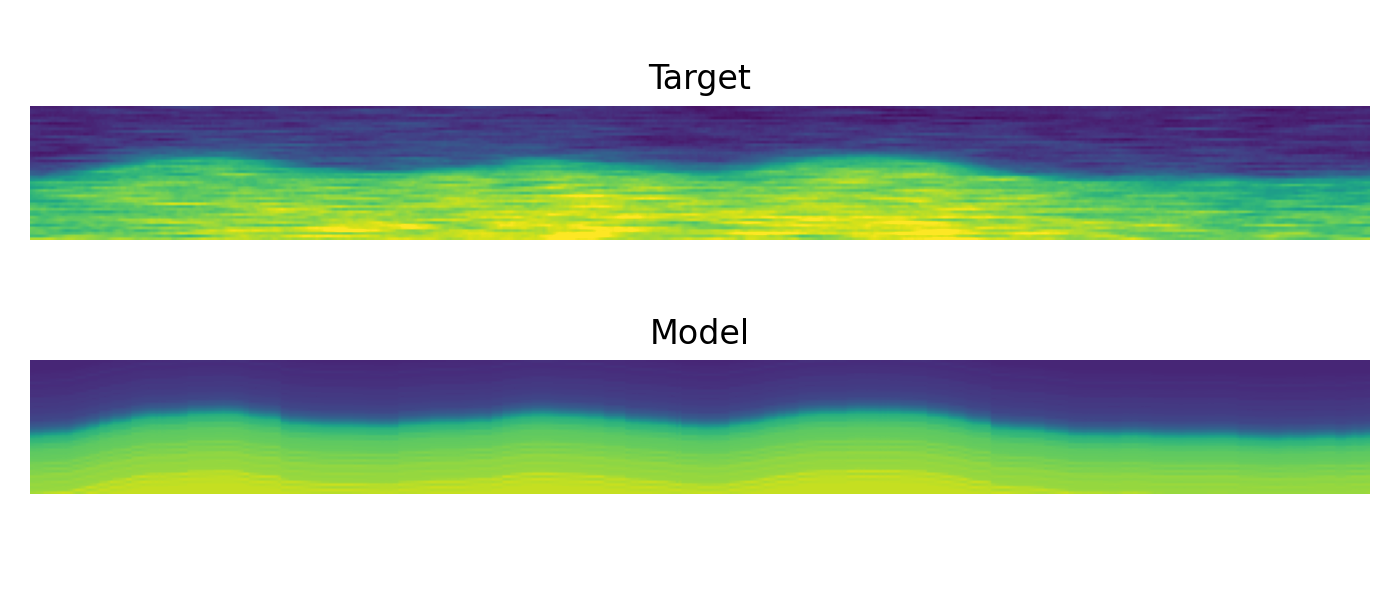

interactive(children=(IntSlider(value=0, description='iteration', max=2000, step=10), Output()), _dom_classes=…

In [7]:
cyt, mems, offsets, cytbg, membg, losses = optimise(target)

### Refine ROI, redo optimisation

In [8]:
# from membranequant.funcs import offset_coordinates, spline_roi

# roi = offset_coordinates(roi, offsets)
# roi = spline_roi(roi=roi, periodic=True, s=100)
# straight = straighten(img, roi=roi, thickness=50)
# target, norm = preprocess(straight)
# cyt, mems, offsets, cytbg, membg, losses = optimise(target)

### View the optimised cytoplasmic reference profile

This profile represents the normalised contribution that cytoplasmic protein in the cell makes to the midplane images. The shape of this profile captures the underlying geometry of the embryo above and below the midplane, as well as the point spread function of light in 3D, without explicitely modelling either. We can see that the intensity of the profile continues increasing as we get further into the cell, reflecting an increase in the thickness of the embryo towards the centre.

A change in cytoplasmic concentration would result in a simple linear scalling of this profile. 

<IPython.core.display.Javascript object>


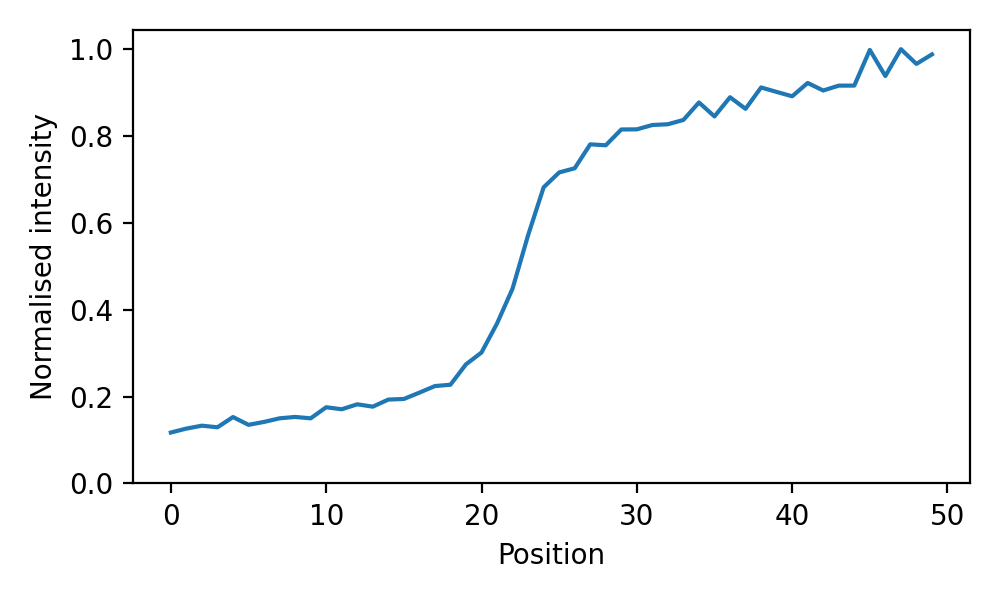

In [9]:
cytbg_norm = cytbg.numpy() / max(cytbg.numpy())

fig, ax = plt.subplots()
ax.plot(cytbg_norm)
ax.set_xlabel('Position')
ax.set_ylabel('Normalised intensity')
ax.set_ylim(bottom=0)
fig.set_size_inches(5,3)
fig.tight_layout()

### Evaluating the final fit
We can see that the model closely resembles the target image:

<IPython.core.display.Javascript object>


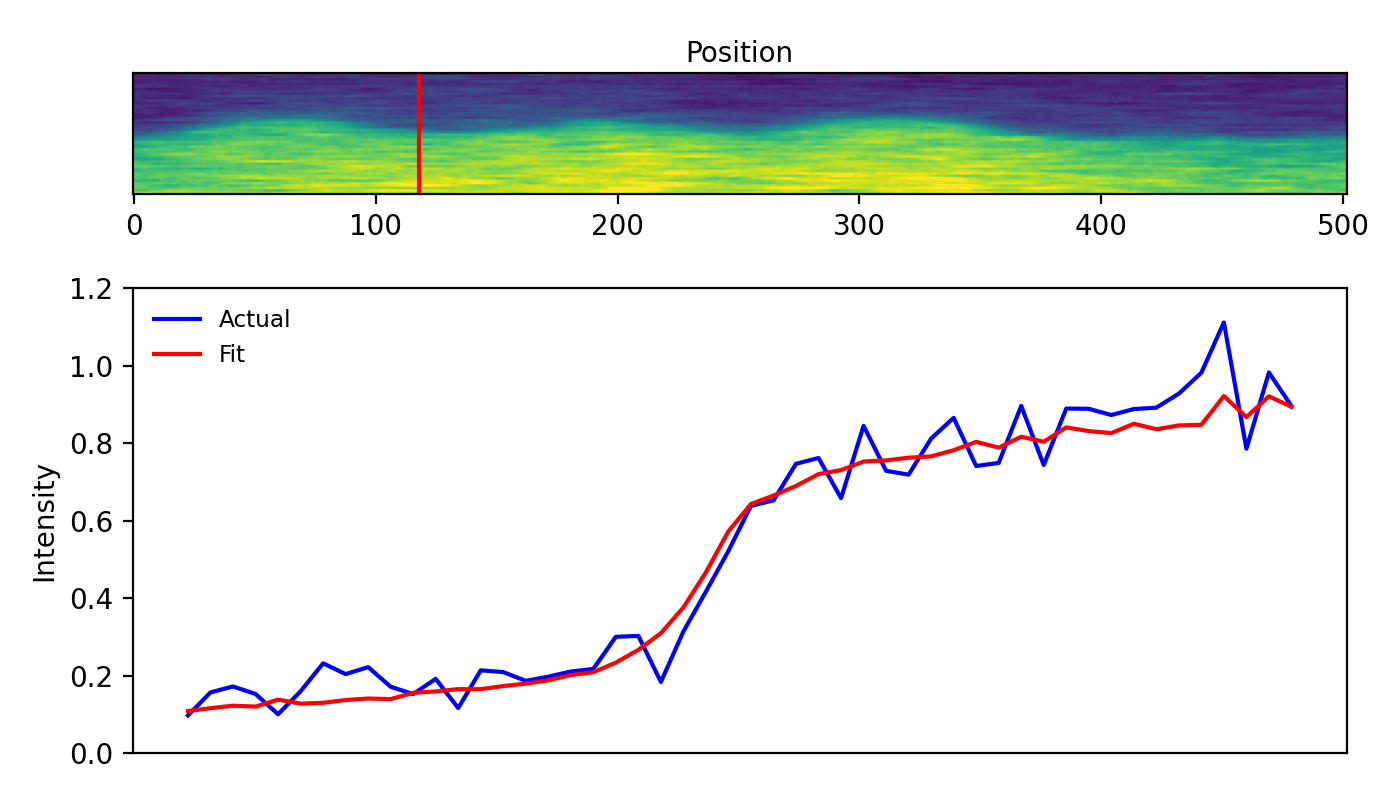

interactive(children=(IntSlider(value=10, description='position', max=501), Output()), _dom_classes=('widget-i…

In [20]:
def evaluate_model_fig():
    fig = plt.figure()
    gs = fig.add_gridspec(3, 3)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1:, :])
    sim = sim_img(cyt, mems, offsets, cytbg, membg)
    @widgets.interact(position=(0, target.shape[1] - 1, 1))
    def update(position=10):
        ax1.clear()
        ax1.imshow(target, vmin=0, vmax=1)
        ax1.axvline(position, c='r')
        ax1.set_yticks([])
        ax1.set_xlabel('Position')
        ax1.xaxis.set_label_position('top')
        ax2.clear()
        ax2.plot(target[:, position], label='Actual', c='b')
        ax2.plot(sim[:, position], label='Fit', c='r')
        ax2.set_xticks([])
        ax2.set_ylabel('Intensity')
        ax2.legend(frameon=False, loc='upper left', fontsize='small')
        ax2.set_ylim(bottom=0, top=1.2)
    fig.set_size_inches(7, 4)
    fig.tight_layout()
    
evaluate_model_fig()

# Learning a membrane reference profile

Whilst it's easy to express a protein that's entirely cytoplasmic, this is not possible for membrane protein. Even a protein with a strong membrane affinity will be manufactured in the cytoplasm, and hence be cytoplasmic to some extent.

An alternative is to consider signal from cells expressing both cytoplasmic and membrane protein, but where the cytoplasmic signal is known or can be unambiguously inferred. If we consider an image of polarised PAR-2, knowing that cytoplasmic concentrations are uniform, we can infer that any extra signal in the posterior is derived from membrane protein. By training our model on this image, using the cytoplasmic profile derived above, we can unambigouusly generate an optimised membrane profile.

<IPython.core.display.Javascript object>


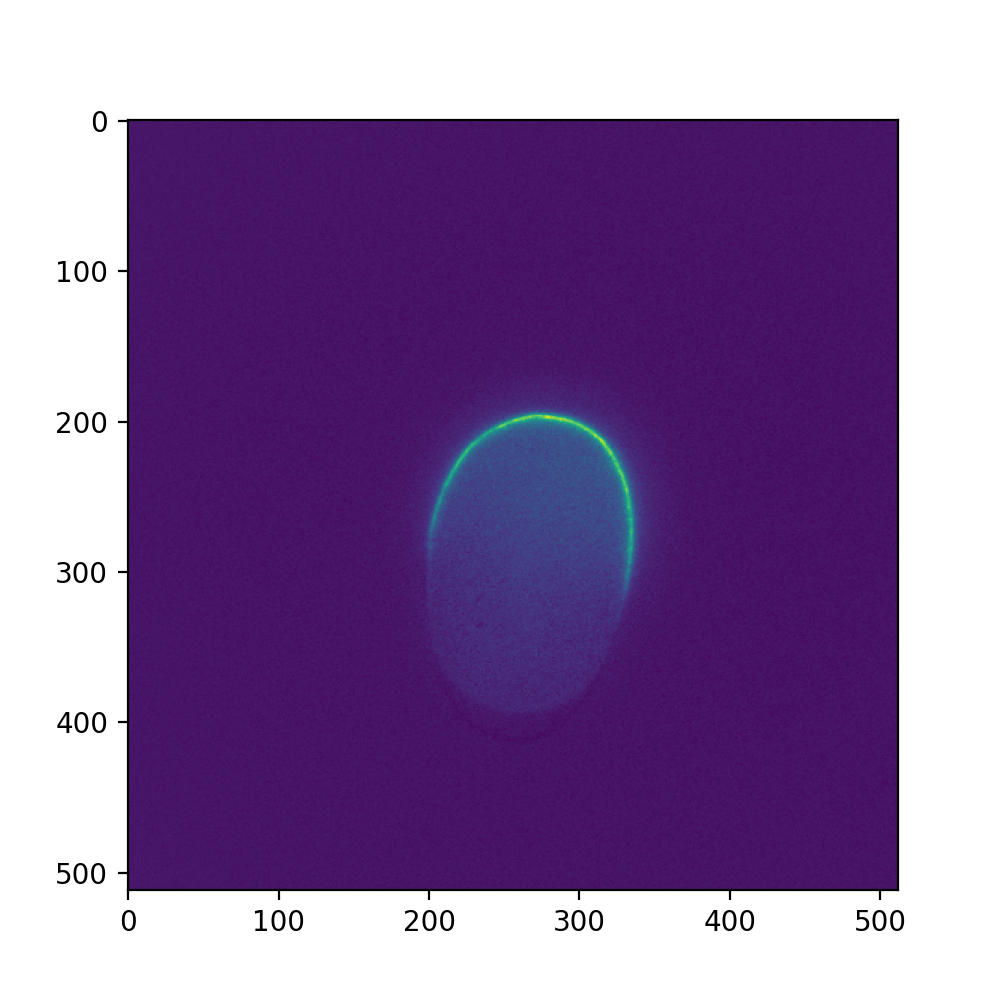

In [11]:
path = '../test_datasets/dataset2_par2_neon/01/'
img_par2 = load_image(path + '/af_corrected.tif')
roi_par2 = np.loadtxt(path + '/ROI.txt')

fig, ax = plt.subplots()
ax.imshow(img_par2)
fig.set_size_inches(5,5)

### Straighten and preprocess image

In [12]:
straight_par2 = straighten(img_par2, roi=roi_par2, thickness=50)
target_par2, norm_par2 = preprocess(straight_par2)

### Initial guess for parameters

We will use the previously derived cytoplasmic profile (this will not be trained further), and initiate the membrane profile as a Gaussian:

In [28]:
def init_params2(target, thickness=50):
    nfits = target.shape[1]
    offsets = tf.Variable(np.zeros(nfits))
    cyt = tf.Variable(np.zeros(nfits))
    mems = tf.Variable(np.zeros(nfits))
    cytbg = tf.Variable(cytbg_norm)
    sigma0 = 2
    membg = tf.Variable(np.exp(-((np.arange(thickness) - thickness / 2) ** 2) / (2 * sigma0 ** 2)))
    return cyt, mems, offsets, cytbg, membg

### Perform gradient descent

All parameters will be optimised by gradient descent, except cytbg which we have previously derived and will be kept fixed (excluded from var_list)

In [14]:
def optimise2(target, lr=0.01, iterations=2000):
    save_gap = 10
    saved = []
    
    # Init parameters
    cyt, mems, offsets, cytbg, membg = init_params2(target)
    
    # Gradient descent
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    losses = np.zeros(iterations)
    for i in tqdm(range(iterations)):   
        with tf.GradientTape() as tape:
            sim = sim_img(cyt, mems, offsets, cytbg, membg)
            loss = loss_function(target, sim)
            losses[i] = loss
            var_list = [offsets, cyt, mems, membg]
            grads = tape.gradient(loss, var_list)
            opt.apply_gradients(list(zip(grads, var_list)))
        
        # Save fit
        if i == 0 or (i + 1) % save_gap == 0: 
            saved.append(sim)
        
    # Interactive plot
    fig, (ax1, ax2) = plt.subplots(2, 1)
    @widgets.interact(iteration=(0, iterations, save_gap))
    def update(iteration=0): 
        ax1.clear()
        ax1.set_title('Target')
        ax1.imshow(target, vmin=0, vmax=1)
        ax1.set_axis_off()      
        ax2.clear()
        ax2.set_title('Model')
        ax2.imshow(saved[int(iteration / save_gap)], vmin=0, vmax=1)
        ax2.set_axis_off()           
    fig.set_size_inches(7, 3)
    fig.tight_layout()
            
    return cyt, mems, offsets, cytbg, membg, losses

100%|██████████| 2000/2000 [00:52<00:00, 38.45it/s]


<IPython.core.display.Javascript object>


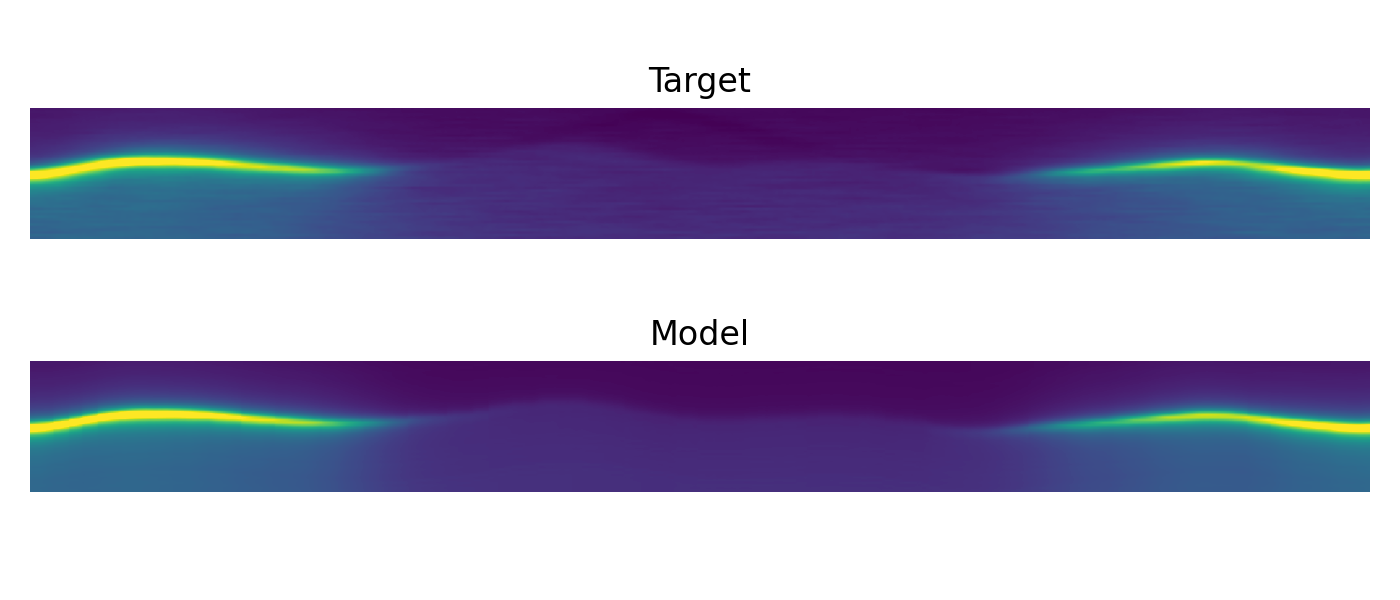

interactive(children=(IntSlider(value=0, description='iteration', max=2000, step=10), Output()), _dom_classes=…

In [15]:
cyt_par2, mems_par2, offsets_par2, cytbg_par2, membg_par2, losses_par2 = optimise2(target_par2)

### Refine ROI, redo optimisation

In [16]:
# roi_par2 = offset_coordinates(roi_par2, offsets_par2)
# roi_par2 = spline_roi(roi=roi_par2, periodic=True, s=100)
# straight_par2 = straighten(img_par2, roi=roi_par2, thickness=50)
# target_par2, norm_par2 = preprocess(straight_par2)
# cyt_par2, mems_par2, offsets_par2, cytbg_par2, membg_par2, losses_par2 = optimise2(target_par2)

### View the optimised cytoplasmic reference profile

We can see that this profile is slightly asymmetric, highlighting the contribution of out of focus membrane protein as we cross into the cell

<IPython.core.display.Javascript object>


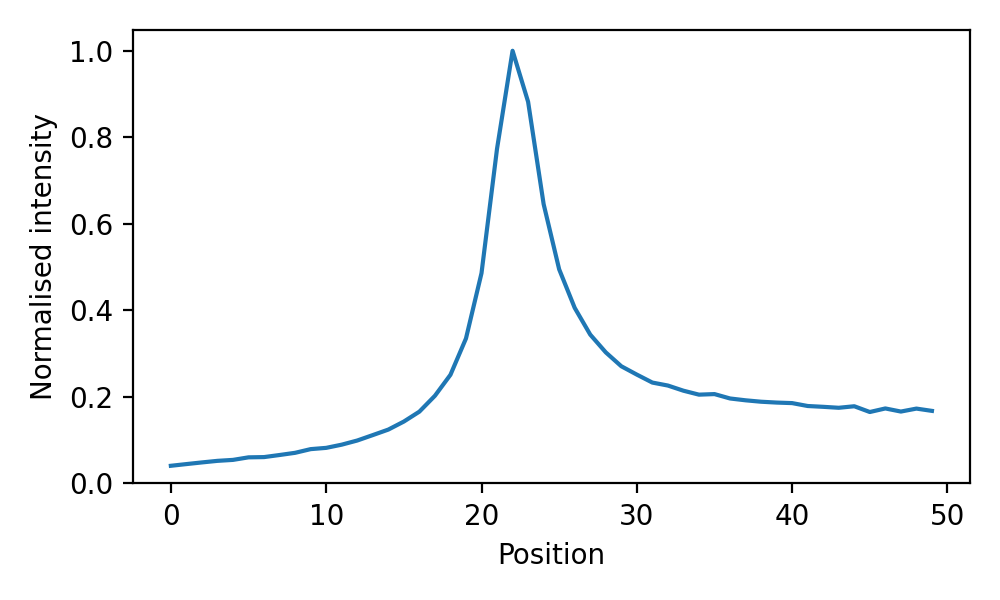

In [24]:
membg_norm = membg_par2.numpy() / max(membg_par2.numpy())

fig, ax = plt.subplots()
ax.plot(membg_norm)
ax.set_xlabel('Position')
ax.set_ylabel('Normalised intensity')
ax.set_ylim(bottom=0)
fig.set_size_inches(5,3)
fig.tight_layout()

### Evaluating the final fit

We can see that the model closely captures the target image:

<IPython.core.display.Javascript object>


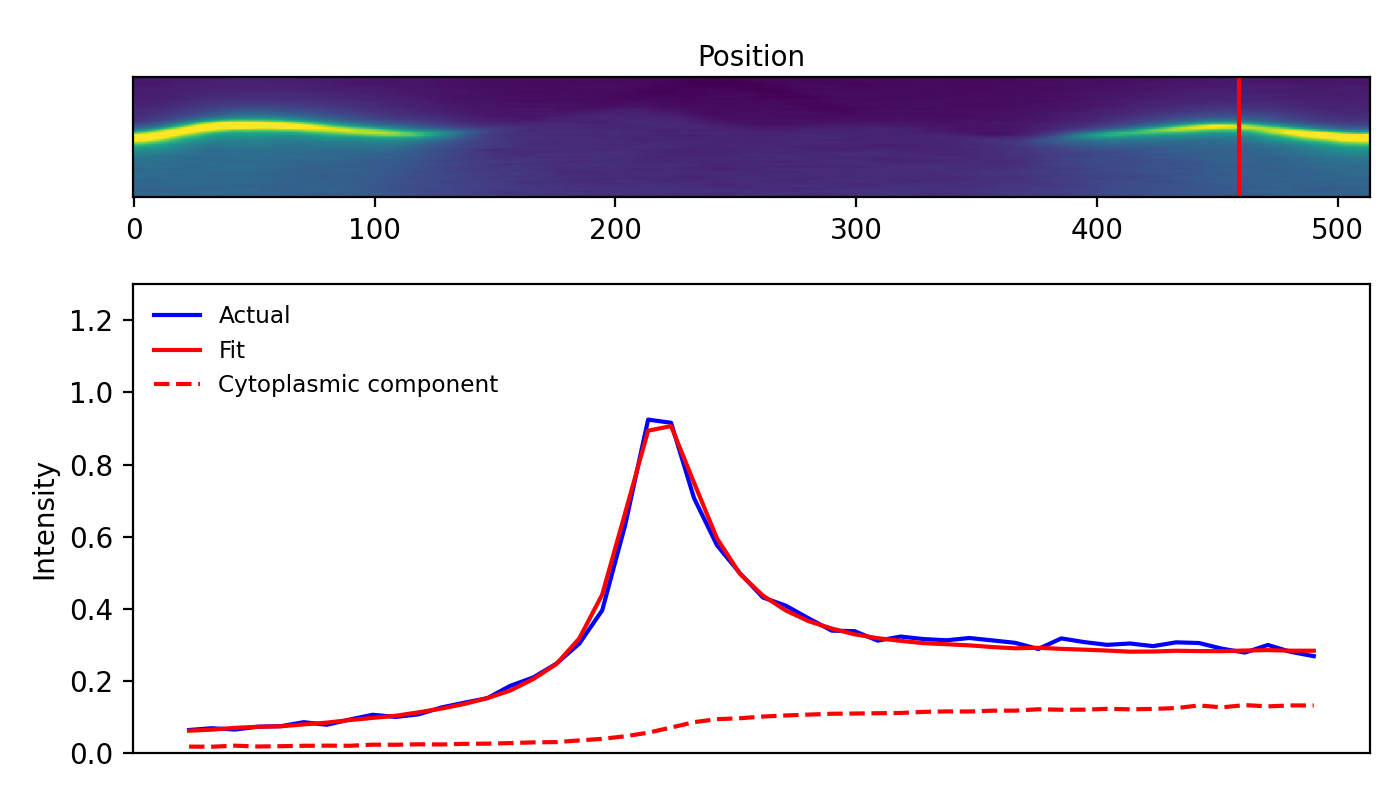

interactive(children=(IntSlider(value=10, description='position', max=513), Output()), _dom_classes=('widget-i…

In [21]:
def evaluate_model_fig():
    fig = plt.figure()
    gs = fig.add_gridspec(3, 3)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1:, :])
    sim = sim_img(cyt_par2, mems_par2, offsets_par2, cytbg_par2, membg_par2)
    sim_cyt = sim_img(cyt_par2, mems_par2 * 0, offsets_par2, cytbg_par2, membg_par2)

    @widgets.interact(position=(0, target_par2.shape[1] - 1, 1))
    def update(position=10):
        ax1.clear()
        ax1.imshow(target_par2, vmin=0, vmax=1)
        ax1.axvline(position, c='r')
        ax1.set_yticks([])
        ax1.set_xlabel('Position')
        ax1.xaxis.set_label_position('top')
        ax2.clear()
        ax2.plot(target_par2[:, position], label='Actual', c='b')
        ax2.plot(sim[:, position], label='Fit', c='r')
        ax2.plot(sim_cyt[:, position], label='Cytoplasmic component', c='r', linestyle='--')
        ax2.set_xticks([])
        ax2.set_ylabel('Intensity')
        ax2.legend(frameon=False, loc='upper left', fontsize='small')
        ax2.set_ylim(bottom=0, top=1.3)
    fig.set_size_inches(7, 4)
    fig.tight_layout()
    
evaluate_model_fig()

### Plot membrane quantification

<IPython.core.display.Javascript object>


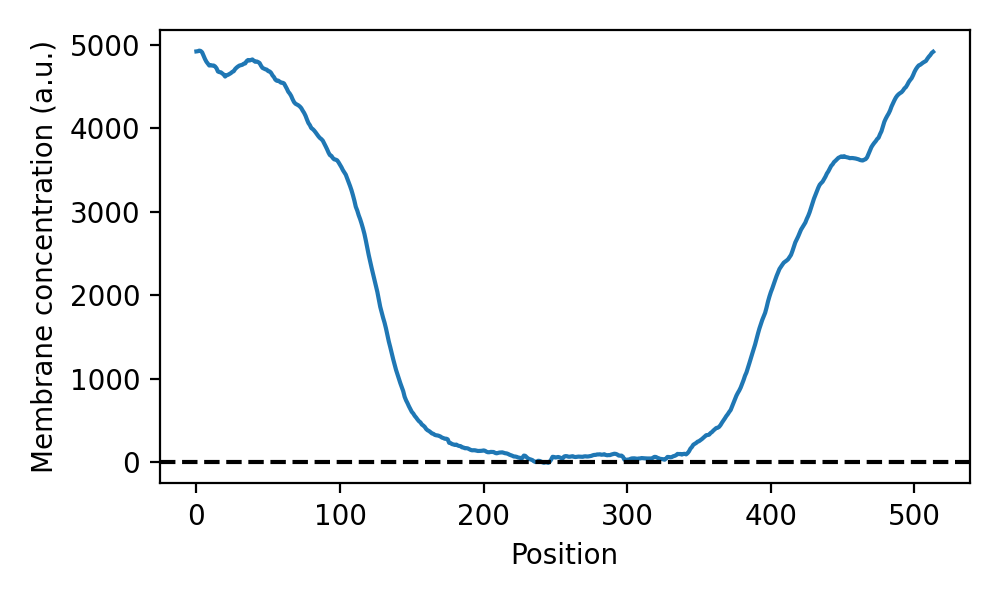

In [27]:
fig, ax = plt.subplots()

ax.plot(mems_par2.numpy() * norm)
ax.axhline(0, c='k', linestyle='--')
ax.set_xlabel('Position')
ax.set_ylabel('Membrane concentration (a.u.)')

fig.set_size_inches(5, 3)
fig.tight_layout()

# Combined model

By training the cytoplasmic component of the model on an image containing only cytoplasmic protien, and the membrane component on an image in which the cytopalsmic component can be unambiguously inferred, be have developed a model that, whilst it doesn't explicitely simulate the geometry and optics of out of focus protein, captures the net outcome of these effects. 

Using the learnt reference profiles, we can simulate the expected shape of the cross-cortex profile as a function of membrane and cytoplasmic concentrations, where concentrations are expressed as units of their respective normalised reference profiles.

This trained model can now be used to quantify other images taken under the same experimental conditions.

<IPython.core.display.Javascript object>


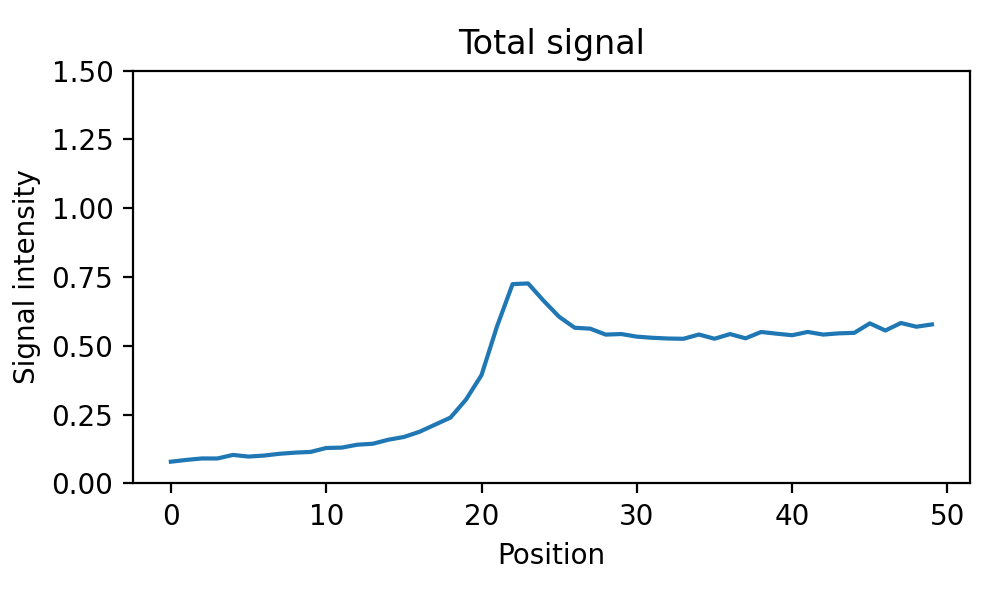

interactive(children=(FloatSlider(value=0.5, description='cyt', max=1.0), FloatSlider(value=1.0, description='…

In [19]:
def fig():
    fig, ax = plt.subplots(1,1)
    @widgets.interact(cyt=(0, 1, 0.1), mem=(0, 1, 0.1))
    def update(cyt=0.5, mem=1): 
        ax.clear()
        ax.set_title('Total signal')
        ax.plot(cyt * cytbg_norm + mem * membg_norm)
        ax.set_xlabel('Position')
        ax.set_ylabel('Signal intensity')
        ax.set_ylim(-0.1, 1.5)
        ax.set_ylim(bottom=0)
    fig.set_size_inches(5,3)
    fig.tight_layout()
    
fig()